In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from __future__ import print_function
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb

Using TensorFlow backend.


In [3]:
# https://github.com/AkshayRaman/EEG-Classification/

import datetime
import os
import random as rn
import json
import subprocess
import sys

import tensorflow as tf
import h5py
import numpy as np

import scipy
from keras import backend as K
from keras.layers import Activation, LSTM, GRU, Dense, Conv1D,\
        MaxPooling1D, GlobalAveragePooling1D, Dropout, Flatten,\
        SimpleRNN, PReLU, BatchNormalization, Conv2D,\
        Conv2DTranspose, MaxPooling2D, GaussianNoise
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
import keras.regularizers as regularizers
from keras.optimizers import Adam, Nadam, SGD
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, TerminateOnNaN,\
        ReduceLROnPlateau, CSVLogger, ModelCheckpoint
from keras.utils import plot_model

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


In [4]:
import os
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm
import glob

row = 3
def prep_data(path):
  data = []
  labels = []
  filenames = [img for img in glob.glob(path)]
  for name in tqdm(filenames):
      df = pd.read_csv(name, header=None, error_bad_lines=False)
      # values = df.values[row - 1]
      values = df.values
      val = sequence.pad_sequences(values, maxlen=30000)
      data.append(val.tolist())
      split = name.split(os.sep)[-2]
      if split == 'control':
        labels.append(0)
      else:
        labels.append(1)

  data = np.asarray(data)
  labels = np.asarray(labels)
  return data,labels

In [5]:
train_x, train_y = prep_data('/content/drive/My Drive/datasets/GB_dataset/train/*/*')

100%|██████████| 63/63 [02:38<00:00,  2.51s/it]


In [6]:
val_x, val_y = prep_data('/content/drive/My Drive/datasets/GB_dataset/val/*/*')

100%|██████████| 23/23 [00:53<00:00,  2.33s/it]


In [7]:
test_x, test_y = prep_data('/content/drive/My Drive/datasets/GB_dataset/test/*/*')

100%|██████████| 11/11 [00:26<00:00,  2.37s/it]


In [8]:
# save numpy array as npy file
from numpy import asarray
from numpy import save

# save to npy file
save('/content/drive/My Drive/saveModels/arrays/GB_train_x.npy', train_x)
save('/content/drive/My Drive/saveModels/arrays/GB_train_y.npy', train_y)
save('/content/drive/My Drive/saveModels/arrays/GB_val_x.npy', val_x)
save('/content/drive/My Drive/saveModels/arrays/GB_val_y.npy', val_y)
save('/content/drive/My Drive/saveModels/arrays/GB_test_x.npy', test_x)
save('/content/drive/My Drive/saveModels/arrays/GB_test_y.npy', test_y)

In [ ]:
# from numpy import load
# train_x = load('/content/drive/My Drive/saveModels/arrays/GB_train_x.npy')
# train_y = load('/content/drive/My Drive/saveModels/arrays/GB_train_y.npy')
# val_x = load('/content/drive/My Drive/saveModels/arrays/GB_val_x.npy')
# val_y = load('/content/drive/My Drive/saveModels/arrays/GB_val_y.npy')
# test_x = load('/content/drive/My Drive/saveModels/arrays/GB_test_x.npy')
# test_y = load('/content/drive/My Drive/saveModels/arrays/GB_test_y.npy')

In [9]:
from keras.utils import to_categorical
train_Y = to_categorical(train_y)
val_Y = to_categorical(val_y)
test_Y = to_categorical(test_y)

In [23]:
dim1 = train_x.shape[1]
dim2 = train_x.shape[2]
filter = 10
model = Sequential()

model.add(Conv1D(filter, 3, activation='relu', input_shape=(dim1, dim2)))
model.add(MaxPooling1D(3))

model.add(LSTM(filter, activation='relu', return_sequences=True))
model.add(LSTM(filter, activation='relu', return_sequences=True))
# model.add(GaussianNoise(stddev=0.5))
model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

# opt = Adam(lr=0.0011, decay=0.001)
opt = Adam()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 12, 10)            900010    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 10)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 4, 10)             840       
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 10)             840       
_________________________________________________________________
flatten_2 (Flatten)          (None, 40)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                

In [24]:
slug = 'muli_july_14_GB'
epoch = 500
batch_size = 16

pathModelSave = '/content/drive/My Drive/saveModels/epi_eeg_conv1D'+'_nigiria_'+'_'+str(batch_size)+'_'+str(epoch)+'_'+slug+'_.hdf5'
pathToSaveCSV = '/content/drive/My Drive/saveModels/csv/epi_eeg_conv1D'+'_nigiria_'+'_'+str(batch_size)+'_'+str(epoch)+'_'+slug+'_.csv'

In [25]:
#Set callbacks...
import time
_patience = min(30, max(epoch//5, 20))
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=_patience, verbose=1, mode='auto')

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=1e-7, verbose=1)
csv_logger = CSVLogger(pathToSaveCSV, append=False, separator=',')
checkpoint = ModelCheckpoint(pathModelSave, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
callback_fns = [csv_logger, checkpoint]

tic = time.clock()
history = model.fit(
    train_x, train_Y, 
    batch_size=batch_size, 
    epochs = epoch, 
    shuffle = False,
    validation_data = (val_x, val_Y), 
    verbose = 1, 
    callbacks = callback_fns)
toc = time.clock()

Train on 63 samples, validate on 23 samples
Epoch 1/500
63/63 [==============================] - 1s 17ms/step - loss: 0.6940 - accuracy: 0.3492 - val_loss: 0.6932 - val_accuracy: 0.4783

Epoch 00001: val_accuracy improved from -inf to 0.47826, saving model to /content/drive/My Drive/saveModels/epi_eeg_conv1D_nigiria__16_500_muli_july_14_GB_.hdf5
Epoch 2/500
63/63 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.4762 - val_loss: 0.6932 - val_accuracy: 0.4783

Epoch 00002: val_accuracy did not improve from 0.47826
Epoch 3/500
63/63 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.4762 - val_loss: 0.6932 - val_accuracy: 0.4783

Epoch 00003: val_accuracy did not improve from 0.47826
Epoch 4/500
63/63 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.4762 - val_loss: 0.6932 - val_accuracy: 0.4783

Epoch 00004: val_accuracy did not improve from 0.47826
Epoch 5/500
63/63 [==============================] - 0s 4ms/s

In [26]:
time = (toc-tic)/60
print("Total training time is: ", time)

Total training time is:  2.329125716666666


In [27]:
_, acc = model.evaluate(val_x, val_Y, verbose=0)
print('validation acc> %.3f' % (acc* 100.0),', bs:',batch_size,', epo:',epoch)

validation acc> 52.174 , bs: 16 , epo: 500


In [28]:
from keras.models import load_model
model_new = load_model(pathModelSave)

_train, acc_train = model_new.evaluate(train_x, train_Y, verbose=0)
print('training acc> %.3f' % (acc_train* 100.0),', bs:',batch_size,', epo:',epoch)

_val, acc_val = model_new.evaluate(val_x, val_Y, verbose=0)
print('val..... acc> %.3f' % (acc_val* 100.0),', bs:',batch_size,', epo:',epoch)

_test, acc_test = model_new.evaluate(test_x, test_Y, verbose=0)
print('testing. acc> %.3f' % (acc_test* 100.0),', bs:',batch_size,', epo:',epoch)

training acc> 52.381 , bs: 16 , epo: 500
val..... acc> 52.174 , bs: 16 , epo: 500
testing. acc> 54.545 , bs: 16 , epo: 500


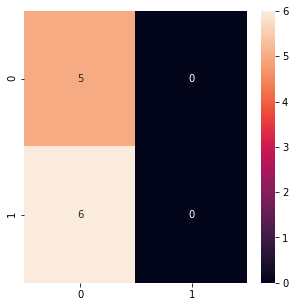

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
Y_prediction = model_new.predict(test_x)
Y_pred_classes = []
for i in Y_prediction:
  if i[0] < 0.5:
    Y_pred_classes.append(0)
  else:
    Y_pred_classes.append(1)

Y_pred_classes = np.asarray(Y_pred_classes)
confusion_mtx = confusion_matrix(test_y, Y_pred_classes)

import seaborn as sns
plt.figure(figsize=(5,5))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

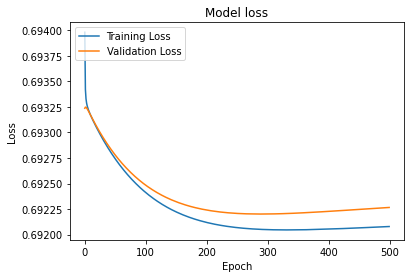

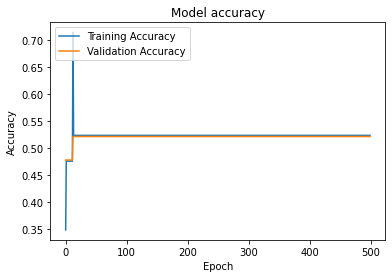

In [30]:
# author Manoj kaushik
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

In [31]:
# testing accuracies
import time
import os
import pandas as pd
import numpy as np
import sys
from keras.models import load_model
model = load_model(pathModelSave)

def predict_fun(filename, type, row):
  list = os.listdir(filename)
  list.sort()
  tic = time.clock()
  count_control = 0
  count = 0
  for name in list:
      count += 1
      file = os.path.join(filename, name)
      df = pd.read_csv(file, header = None, error_bad_lines = False)
      values = df.values[row - 1]
      data = []
      data.append(values.tolist())
      data = np.asarray(data)
      values = sequence.pad_sequences(data, maxlen = maxlen)
      p = model.predict(values)[0][0]
      if p < 0.5:
        count_control += 1
      #   print(count, '. ', name, ": Control predicted")
      # else :
      #   print(count, '. ', name, ": Epilipsy Pridicted")
  toc = time.clock()
  total_ele = len(list)
  print('total files of ' + str(type)+' are :', count, ' control predicted:', count_control, ' epilipsy predicted:', count - count_control, '| row',row)

In [32]:
# total files of control are : 93  control predicted: 91  epilipsy predicted: 2 | row 8
# total files of epilipsy are : 128  control predicted: 21  epilipsy predicted: 107 | row 8

# total files of control are : 46  control predicted: 15  epilipsy predicted: 31 | row 2
# total files of epilipsy are : 51  control predicted: 14  epilipsy predicted: 37 | row 2

In [33]:
# predict_fun('/content/drive/My Drive/datasets/EEGs_Nigeria_transposed/control/', 'control', 8)
# predict_fun('/content/drive/My Drive/datasets/EEGs_Nigeria_transposed/epilipsy/', 'epilipsy', 8)

In [34]:
# predict_fun('/content/drive/My Drive/datasets/EEGs_Guinea-Bissau_classified/control/', 'control', 2)
# predict_fun('/content/drive/My Drive/datasets/EEGs_Guinea-Bissau_classified/epilipsy/', 'epilipsy', 2)

In [44]:
import plotly
plotly.io.renderers.default = 'colab'
# example
import plotly.graph_objects as go
fig = go.Figure( go.Scatter(x=[1,2,3], y=[1,3,2] ) )
fig.show()